part 1 : basic code

In [ ]:
import pandas as pd

# Load the data
file_path = '/content/household_power_consumption[1].txt'
data = pd.read_csv(file_path, sep=';', parse_dates={'datetime': ['Date', 'Time']}, infer_datetime_format=True, low_memory=False, na_values=['nan','?'])

# Filter data for January 2007
data = data[(data['datetime'] >= '2007-01-01') & (data['datetime'] < '2007-02-01')]

# Resample the data to hourly intervals, taking the mean of each hour
data.set_index('datetime', inplace=True)
hourly_data = data.resample('H').mean()

# Display the first few rows of the processed hourly data
hourly_data.head()


<ipython-input-4-2b6f5591b883>:5: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv(file_path, sep=';', parse_dates={'datetime': ['Date', 'Time']}, infer_datetime_format=True, low_memory=False, na_values=['nan','?'])
<ipython-input-4-2b6f5591b883>:5: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data = pd.read_csv(file_path, sep=';', parse_dates={'datetime': ['Date', 'Time']}, infer_datetime_format=True, low_memory=False, na_values=['nan','?'])


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2007-01-01 00:00:00,2.550633,0.112800,241.361333,10.530000,0.0,0.583333,0.0
2007-01-01 01:00:00,2.523400,0.071633,241.096500,10.443333,0.0,0.000000,0.0
2007-01-01 02:00:00,2.582333,0.106667,243.200167,10.540000,0.0,0.333333,0.0
2007-01-01 03:00:00,2.541667,0.090100,243.265667,10.400000,0.0,0.266667,0.0
2007-01-01 04:00:00,2.475733,0.088167,242.456167,10.110000,0.0,0.000000,0.0


In [ ]:
pip install tensorflow

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler

# Extract the relevant feature (e.g., Global_active_power) for prediction
feature = 'Global_active_power'
hourly_data = hourly_data[[feature]].dropna()

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(hourly_data)

# Prepare the dataset for LSTM
def create_dataset(dataset, look_back=24):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 24
X, Y = create_dataset(scaled_data, look_back)

# Reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(X, Y, epochs=20, batch_size=1, verbose=2)


Epoch 1/20
719/719 - 23s - loss: 0.0287 - 23s/epoch - 33ms/step
Epoch 2/20
719/719 - 10s - loss: 0.0187 - 10s/epoch - 15ms/step
Epoch 3/20
719/719 - 10s - loss: 0.0175 - 10s/epoch - 14ms/step
Epoch 4/20
719/719 - 9s - loss: 0.0170 - 9s/epoch - 13ms/step
Epoch 5/20
719/719 - 14s - loss: 0.0168 - 14s/epoch - 19ms/step
Epoch 6/20
719/719 - 12s - loss: 0.0168 - 12s/epoch - 17ms/step
Epoch 7/20
719/719 - 10s - loss: 0.0161 - 10s/epoch - 14ms/step
Epoch 8/20
719/719 - 10s - loss: 0.0160 - 10s/epoch - 13ms/step
Epoch 9/20
719/719 - 9s - loss: 0.0160 - 9s/epoch - 12ms/step
Epoch 10/20
719/719 - 10s - loss: 0.0157 - 10s/epoch - 15ms/step
Epoch 11/20
719/719 - 9s - loss: 0.0157 - 9s/epoch - 13ms/step
Epoch 12/20
719/719 - 8s - loss: 0.0158 - 8s/epoch - 12ms/step
Epoch 13/20
719/719 - 10s - loss: 0.0158 - 10s/epoch - 14ms/step
Epoch 14/20
719/719 - 9s - loss: 0.0153 - 9s/epoch - 12ms/step
Epoch 15/20
719/719 - 9s - loss: 0.0159 - 9s/epoch - 13ms/step
Epoch 16/20
719/719 - 10s - loss: 0.0157 - 10s

1/1 [==============================] - 0s 23ms/step


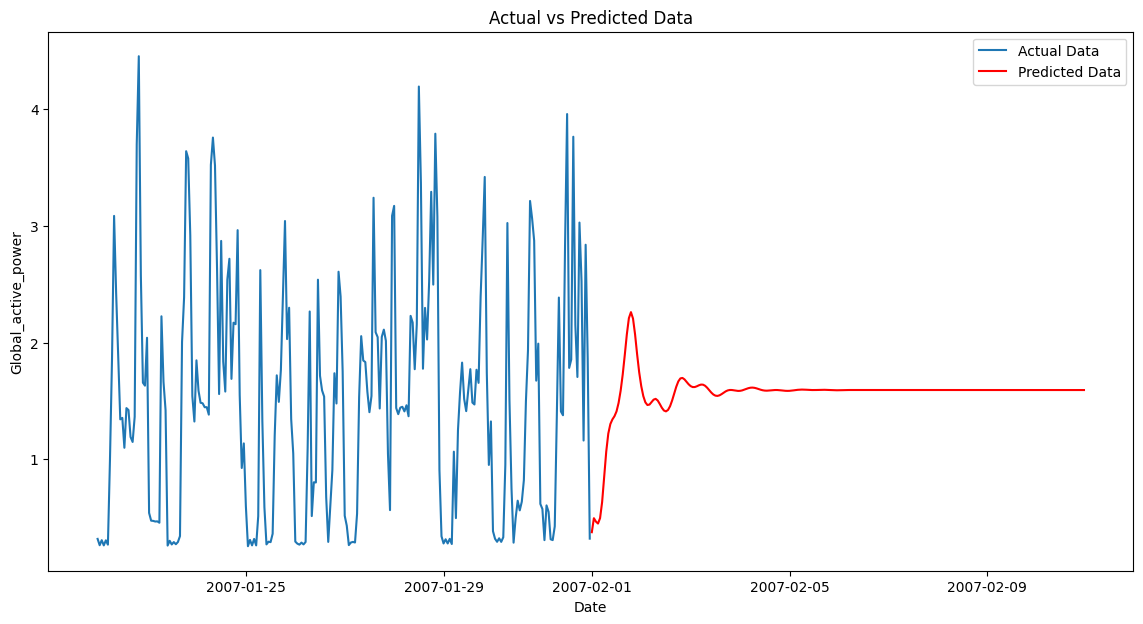

In [ ]:
# Predict the next 10 days (240 hours)
num_predictions = 240
predictions = []
input_seq = scaled_data[-look_back:]  # last look_back hours of data

for _ in range(num_predictions):
    input_seq = np.reshape(input_seq, (1, look_back, 1))
    pred = model.predict(input_seq)
    predictions.append(pred[0, 0])
    input_seq = np.append(input_seq[:, 1:, :], pred.reshape(1, 1, 1), axis=1)

# Inverse transform the predictions
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Create a DataFrame to store the results
pred_dates = pd.date_range(start=hourly_data.index[-1], periods=num_predictions + 1, freq='H')[1:]
pred_df = pd.DataFrame(predictions, index=pred_dates, columns=[feature])

# Compare the actual and predicted data
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(hourly_data[-24*10:], label='Actual Data')
plt.plot(pred_df, label='Predicted Data', color='red')
plt.xlabel('Date')
plt.ylabel(feature)
plt.title('Actual vs Predicted Data')
plt.legend()
plt.show()

part 2 : using CNN

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Select the columns of interest
columns_of_interest = ['Global_active_power', 'Global_intensity']
hourly_data = hourly_data[columns_of_interest].dropna()

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(hourly_data)

# Function to create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Create sequences
SEQ_LENGTH = 24  # 24 hours for a day
X, y = create_sequences(scaled_data, SEQ_LENGTH)

# Split data into training and testing sets
split_index = int(0.8 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten

# Define the CNN model
model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(SEQ_LENGTH, len(columns_of_interest))),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(len(columns_of_interest))
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))


Epoch 1/20
18/18 [==============================] - 2s 29ms/step - loss: 0.0411 - val_loss: 0.0250
Epoch 2/20
18/18 [==============================] - 0s 11ms/step - loss: 0.0230 - val_loss: 0.0196
Epoch 3/20
18/18 [==============================] - 0s 12ms/step - loss: 0.0187 - val_loss: 0.0197
Epoch 4/20
18/18 [==============================] - 0s 9ms/step - loss: 0.0172 - val_loss: 0.0171
Epoch 5/20
18/18 [==============================] - 0s 10ms/step - loss: 0.0152 - val_loss: 0.0164
Epoch 6/20
18/18 [==============================] - 0s 11ms/step - loss: 0.0143 - val_loss: 0.0164
Epoch 7/20
18/18 [==============================] - 0s 11ms/step - loss: 0.0141 - val_loss: 0.0163
Epoch 8/20
18/18 [==============================] - 0s 11ms/step - loss: 0.0139 - val_loss: 0.0162
Epoch 9/20
18/18 [==============================] - 0s 11ms/step - loss: 0.0138 - val_loss: 0.0161
Epoch 10/20
18/18 [==============================] - 0s 11ms/step - loss: 0.0133 - val_loss: 0.0164
Epoch 11/2

In [ ]:
# Predict the next 10 days (240 hours)
predictions = []
input_seq = X_test[-1]  # Start with the last sequence in the test set

for _ in range(240):  # 10 days * 24 hours
    pred = model.predict(input_seq[np.newaxis, ...])
    predictions.append(pred[0])
    input_seq = np.append(input_seq[1:], pred, axis=0)  # Slide the window

# Inverse transform the predictions
predictions = scaler.inverse_transform(predictions)


1/1 [==============================] - 0s 30ms/step


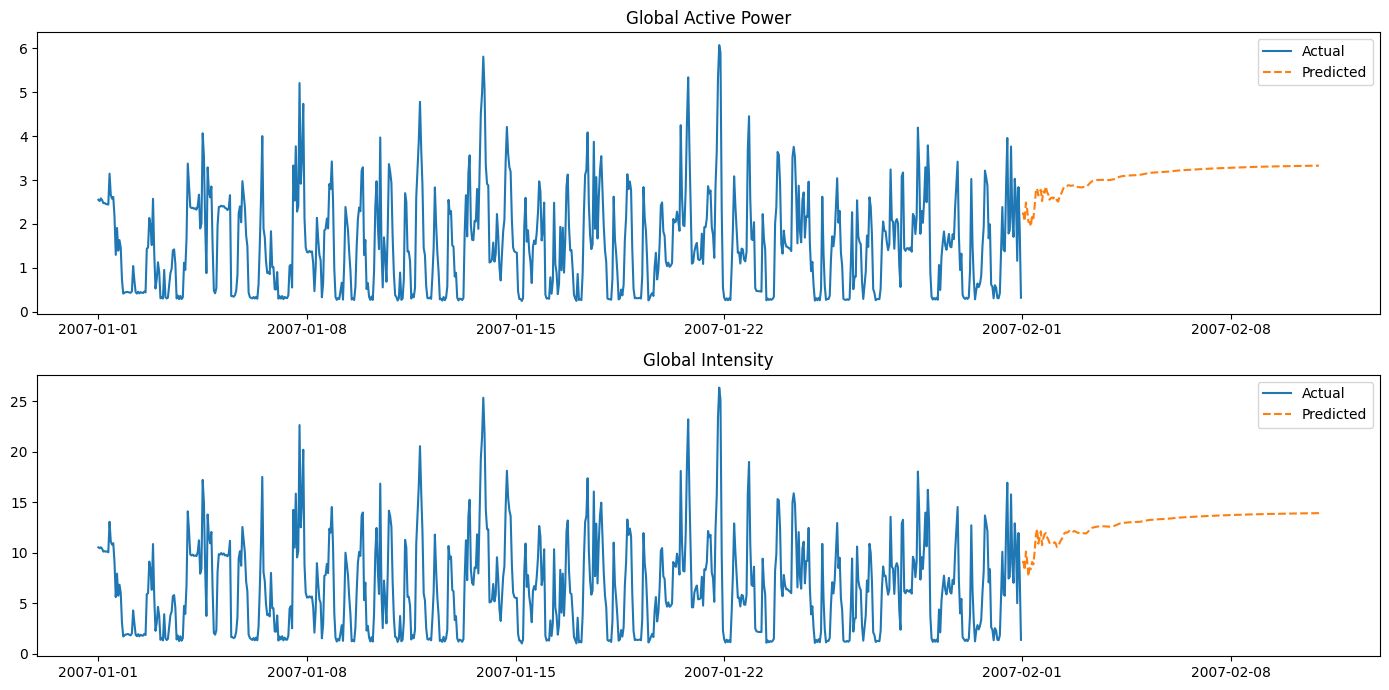

In [ ]:
import matplotlib.pyplot as plt

# Create a DataFrame for easy plotting
pred_df = pd.DataFrame(predictions, columns=columns_of_interest, index=pd.date_range(start=hourly_data.index[-1] + pd.Timedelta(hours=1), periods=240, freq='H'))

# Plot the results
plt.figure(figsize=(14, 7))

# Plot Global_active_power
plt.subplot(2, 1, 1)
plt.plot(hourly_data.index, hourly_data['Global_active_power'], label='Actual')
plt.plot(pred_df.index, pred_df['Global_active_power'], label='Predicted', linestyle='dashed')
plt.title('Global Active Power')
plt.legend()

# Plot Global_intensity
plt.subplot(2, 1, 2)
plt.plot(hourly_data.index, hourly_data['Global_intensity'], label='Actual')
plt.plot(pred_df.index, pred_df['Global_intensity'], label='Predicted', linestyle='dashed')
plt.title('Global Intensity')
plt.legend()

plt.tight_layout()
plt.show()


part 3 : using CNN with detailed explaination

In [ ]:
import pandas as pd

file_path = '/content/household_power_consumption.txt'
data = pd.read_csv(file_path, sep=';', parse_dates={'datetime': ['Date', 'Time']},
                   infer_datetime_format=True, low_memory=False, na_values=['?'])


<ipython-input-32-4502062636c0>:4: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv(file_path, sep=';', parse_dates={'datetime': ['Date', 'Time']},
<ipython-input-32-4502062636c0>:4: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data = pd.read_csv(file_path, sep=';', parse_dates={'datetime': ['Date', 'Time']},


In [ ]:
data['datetime'] = pd.to_datetime(data['datetime'], format='%d/%m/%Y %H:%M:%S')
data_jan_2007 = data[(data['datetime'] >= '2007-01-01') & (data['datetime'] < '2007-02-01')]


In [ ]:
data_jan_2007.set_index('datetime', inplace=True)
data_hourly = data_jan_2007.resample('H').mean()

In [ ]:
features = data_hourly[['Global_active_power', 'Global_intensity']].values
target_active_power = data_hourly['Global_active_power'].values
target_intensity = data_hourly['Global_intensity'].values


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)


In [ ]:
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 24  # Use past 24 hours to predict the next hour
X, y_active_power = create_sequences(features_scaled, SEQ_LENGTH)
_, y_intensity = create_sequences(target_intensity, SEQ_LENGTH)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten

model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(SEQ_LENGTH, features_scaled.shape[1])),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')


In [ ]:
model.fit(X, y_active_power, epochs=10, validation_split=0.2)


Epoch 1/10
18/18 [==============================] - 3s 15ms/step - loss: 0.0316 - val_loss: 0.0231
Epoch 2/10
18/18 [==============================] - 0s 8ms/step - loss: 0.0216 - val_loss: 0.0190
Epoch 3/10
18/18 [==============================] - 0s 6ms/step - loss: 0.0180 - val_loss: 0.0189
Epoch 4/10
18/18 [==============================] - 0s 6ms/step - loss: 0.0158 - val_loss: 0.0169
Epoch 5/10
18/18 [==============================] - 0s 7ms/step - loss: 0.0143 - val_loss: 0.0170
Epoch 6/10
18/18 [==============================] - 0s 6ms/step - loss: 0.0148 - val_loss: 0.0159
Epoch 7/10
18/18 [==============================] - 0s 7ms/step - loss: 0.0130 - val_loss: 0.0159
Epoch 8/10
18/18 [==============================] - 0s 6ms/step - loss: 0.0128 - val_loss: 0.0161
Epoch 9/10
18/18 [==============================] - 0s 7ms/step - loss: 0.0123 - val_loss: 0.0154
Epoch 10/10
18/18 [==============================] - 0s 7ms/step - loss: 0.0121 - val_loss: 0.0155


In [ ]:
import numpy as np

predictions_active_power = []
input_seq = X[-1]  # Last sequence from the training data

for _ in range(10*24):  # Predict next 10 days (24 hours each)
    pred = model.predict(input_seq.reshape(1, SEQ_LENGTH, features_scaled.shape[1]))
    predictions_active_power.append(pred[0, 0])  # Extract the prediction value

    # Update the input sequence for the next prediction
    input_seq = np.vstack((input_seq[1:], [pred[0, 0], input_seq[-1, 1]]))  # Assume the second feature remains the same

predictions_active_power = np.array(predictions_active_power)

1/1 [==============================] - 0s 23ms/step


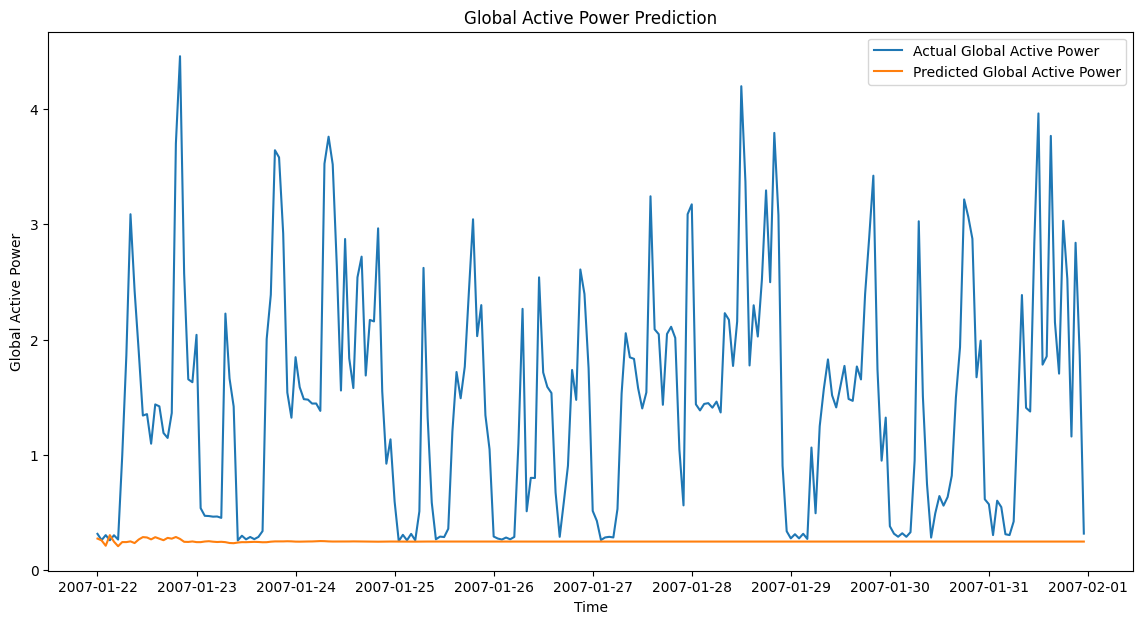

In [ ]:
import matplotlib.pyplot as plt

# Last 10 days of actual values
actual_values = target_active_power[-10*24:]

# Index for the last 10 days
time_index = data_hourly.index[-10*24:]

plt.figure(figsize=(14, 7))
plt.plot(time_index, actual_values, label='Actual Global Active Power')
plt.plot(time_index, predictions_active_power, label='Predicted Global Active Power')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Global Active Power')
plt.title('Global Active Power Prediction')
plt.show()